<a href="https://colab.research.google.com/github/fernandojunior/deteccao-fraude/blob/master/src/Fraud_Detection_Xente.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spark load lib

In [1]:
'''!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install pandas_ml
!pip install -q findspark
!pip install catboost
!pip install -U imbalanced-learn
!pip install pyod seaborn catboost plotly_express==0.4.0
!pip install --upgrade pyod
!pip install shap
!pip install --user --upgrade ipywidgets
!jupyter nbextension enable --py widgetsnbextension
#!pip install -r requirements.txt

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"
'''
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('xente').getOrCreate()
spark

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pyspark.sql.functions as F
import shap
import catboost
from catboost import Pool, CatBoostClassifier, cv

from pyspark.sql.types import IntegerType, DoubleType
from pyspark.sql.functions import mean, udf, array, col
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.linalg import Vectors
from imblearn.over_sampling import RandomOverSampler, SMOTE, SMOTENC, ADASYN
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split, learning_curve, ShuffleSplit, GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                              f1_score, precision_score, recall_score, roc_curve, roc_auc_score)

# Load Training Data

In [2]:
def read_data_from_web(url):
  data = pd.read_csv(url)
  spark_data = spark.createDataFrame(data)
  return spark_data

#fraud_data = read_data_from_web("https://drive.google.com/uc?export=download&id=1NrtVkKv8n_g27w5elq9HWZA1i8aFBW0G")
fraud_data = spark.read.csv('training.csv', inferSchema=True, header=True)

## Data Dictionary

*   **TransactionId:** Unique transaction identifier on platform.
*   **BatchId:** Unique number assigned to a batch of transactions for processing.
*   **AccountId:** Unique number identifying the customer on platform.
*   **SubscriptionId:** Unique number identifying the customer subscription.
*   **CustomerId:** Unique identifier attached to Account.
*   **CurrencyCode:** Country currency.
*   **CountryCode:** Numerical geographical code of country.
*   **ProviderId:** Source provider of Item bought.
*   **ProductId:** Item name being bought.
*   **ProductCategory:** ProductIds are organized into these broader product categories.
*   **ChannelId:** Identifies if customer used web,Android, IOS, pay later or checkout.
*   **Amount:** Value of the transaction. Positive for debits from customer account and negative for credit into customer account.
*   **Value:** Absolute value of the amount.
*   **TransactionStartTime:** Transaction start time.
*   **PricingStrategy:** Category of Xente's pricing structure for merchants.
*   **FraudResult:** Fraud status of transaction: 1) Yes; or 0) No.

# Data Preprocessing

## Missing Data Analysis

In [3]:
def there_is_missing_data(data):
  return data.count() != data.na.drop(how='any').count()

print('There is missing data? {0}.'.format(there_is_missing_data(fraud_data)))

There is missing data? False.


## Duplicated line?

In [4]:
def there_is_duplicate_lines(data):
  return data.count() != data.distinct().count()

print('There is distinct data? {0}.'.format(there_is_duplicate_lines(fraud_data)))

There is distinct data? False.


## Data Treatment

In [5]:
def get_val_transac(df):
    column_val = df.withColumn('diff', F.abs(df['Amount'])-F.col('Value')).select('diff').show()
    zero_qtty = df.withColumn('diff', F.abs(df['Amount'])-F.col('Value')).select('diff').groupBy('diff').count().filter('diff == 0').show()
    return column_val, zero_qtty

In [6]:
column_val_ret, zero_qtty_ret = get_val_transac(fraud_data)

+-------+
|   diff|
+-------+
|    0.0|
|    0.0|
|    0.0|
|-1800.0|
|    0.0|
|    0.0|
|    0.0|
|    0.0|
|    0.0|
|    0.0|
|    0.0|
|    0.0|
|    0.0|
|    0.0|
|    0.0|
|    0.0|
|    0.0|
|    0.0|
|    0.0|
|    0.0|
+-------+
only showing top 20 rows

+----+-----+
|diff|count|
+----+-----+
| 0.0|93097|
+----+-----+



It shows the real transaction value. To be precise, we need to categorize the transaction, but first, let us remove unuseful features.

## Removing unuseful features

In [7]:
def columns_values_sorted(df): 
    arr_columns = []
    for i in df.toPandas().columns:
        arr_columns.append((i, df.select(i).distinct().count()))
    arr_columns.sort(key = lambda x: x[1])
    return arr_columns

In [8]:
columns_values_sorted(fraud_data)

[('CurrencyCode', 1),
 ('CountryCode', 1),
 ('FraudResult', 2),
 ('ChannelId', 4),
 ('PricingStrategy', 4),
 ('ProviderId', 6),
 ('ProductCategory', 9),
 ('ProductId', 23),
 ('Value', 1517),
 ('Amount', 1676),
 ('SubscriptionId', 3627),
 ('AccountId', 3633),
 ('CustomerId', 3742),
 ('TransactionStartTime', 94556),
 ('BatchId', 94809),
 ('TransactionId', 95662)]

CurrencyCode and CountryCode columns have the same value in whole dataset, genuine or fraud.

In [9]:
# data: dataframe - columns: column list to remove
def remove_feature(data, columns_in):
  return data.drop(*columns_in)

In [10]:
def clean_data(fraud_data, columns_to_remove):
  fraud_data = remove_feature(fraud_data, columns_to_remove)
  return fraud_data

In [11]:
columns_to_remove = ['CurrencyCode','CountryCode','BatchId','SubscriptionId','CustomerId', 'TransactionStartTime']
fraud_data = clean_data(fraud_data, columns_to_remove)

# Creating and Removing Features

In [12]:
fraud_data = fraud_data.withColumn("Operation", F.when(fraud_data.Amount > 0, 1).when(fraud_data.Amount < 0, -1).otherwise(0))
fraud_data = fraud_data.withColumn('PositiveAmount', F.abs(fraud_data['Amount']))

In [13]:
def get_features_augmentation(df, clean=False):
  gen_train_data = df.filter('FraudResult == 0')
  items_list = ['AccountId', 'ChannelId', 'ProductCategory', 'ProductId']

  for item in items_list:
    mean_column_name = 'avg_ps_{0}'.format(item)
    mean_aux = gen_train_data.select([item,'PositiveAmount']).groupBy(item).mean()
    mean_aux = mean_aux.select(col(item), col('avg(PositiveAmount)').alias(mean_column_name))
    df = df.join(mean_aux, on=item)

    min_column_name = 'min_ps_{0}'.format(item)
    min_aux = gen_train_data.select([item,'PositiveAmount']).groupBy(item).min()    
    min_aux = min_aux.select(col(item), col('min(PositiveAmount)').alias(min_column_name))
    df = df.join(min_aux, on=item)

    max_column_name = 'max_ps_{0}'.format(item)
    max_aux = gen_train_data.select([item,'PositiveAmount']).groupBy(item).max()    
    max_aux = max_aux.select(col(item), col('max(PositiveAmount)').alias(max_column_name))
    df = df.join(max_aux, on=item)
    
    ratio_column_name = 'rt_avg_ps_{0}'.format(item)
    df = df.withColumn(ratio_column_name, (F.col('PositiveAmount')-F.col(mean_column_name))/ F.col(mean_column_name))
  
  if clean:
    df = clean_data(df)
  
  return df

In [14]:
fraud_data = get_features_augmentation(fraud_data)
fraud_data = clean_data(fraud_data, columns_to_remove = ['Amount'])

# Data Analysis

ProductCategory have a bias to fraud transaction

In [15]:
def column_qtty_by_typeTransac(df, column):
    column_by_gen = df.filter('FraudResult == 0').groupBy(column).count().show()
    column_by_frd = df.filter('FraudResult == 1').groupBy(column).count().show()
    return column_by_gen, column_by_frd

In [16]:
column_qtty_by_typeTransac(fraud_data, 'ProductCategory')

+------------------+-----+
|   ProductCategory|count|
+------------------+-----+
|            ticket|  216|
|                tv| 1279|
|             other|    2|
|           airtime|45009|
|         transport|   23|
|      data_bundles| 1613|
|            movies|  175|
|      utility_bill| 1908|
|financial_services|45244|
+------------------+-----+

+------------------+-----+
|   ProductCategory|count|
+------------------+-----+
|           airtime|   18|
|         transport|    2|
|      utility_bill|   12|
|financial_services|  151|
+------------------+-----+



(None, None)

Counting the number of transactions by category, let us normalize and show in histogram graphic.

Percebe-se que as transações fraudulentas (representadas em azul), incidem principalmente em operações do tipo Serviço financeiro, como também Airtime e Utility_bill.

In [17]:
def plot_column_desc(df, column):
    df1 = df.filter('FraudResult == 0').groupBy(column ).count()
    df1 = df1.withColumnRenamed('count', 'gen_count')

    df2 = df.filter('FraudResult == 1').groupBy(column ).count()
    df2 = df2.withColumnRenamed('count', 'fraud_count')

    new_df = df1.join(df2, on=[column], how='left_outer')
    new_df = new_df.fillna({'fraud_count': '0'})

    new_df_pd = new_df.toPandas()
    new_df_pd['gen_count'] = new_df_pd['gen_count']/sum(new_df_pd['gen_count'])
    new_df_pd['fraud_count'] = new_df_pd['fraud_count']/sum(new_df_pd['fraud_count'])
    new_df_pd = pd.melt(new_df_pd, id_vars=column, value_vars=['fraud_count', 'gen_count'], value_name='value')

    sns.catplot(y=column, hue='variable', x='value', kind='bar', data=new_df_pd);
    pass

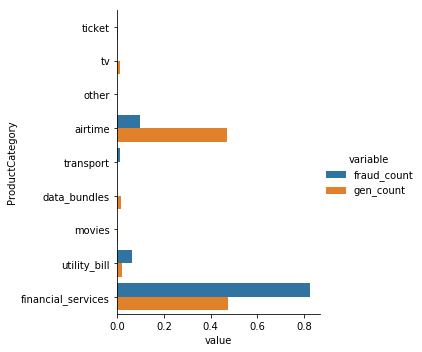

In [18]:
plot_column_desc(fraud_data, 'ProductCategory')

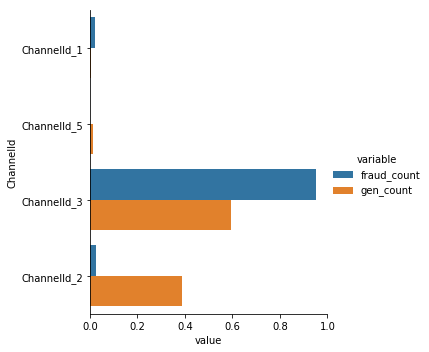

In [19]:
plot_column_desc(fraud_data, 'ChannelId')

# Statistics

## Imbalanced dataset

In [20]:
def get_percent_contamination(df):
    outlier_fraction = df.filter("FraudResult == 1").count() / df.filter("FraudResult == 0").count()
    return outlier_fraction*100

In [21]:
print('Os dados fraudulentos representam {0:.3f}% dos dados.'.format(get_percent_contamination(fraud_data)))

Os dados fraudulentos representam 0.192% dos dados.


## Descriptive analysis of numerical variables

### Value descriptions

In [22]:
all_features = ['ProductId','ProductCategory','ChannelId','AccountId','TransactionId',
                            'ProviderId','Value','PricingStrategy','Operation', 'PositiveAmount',
                            'avg_ps_AccountId','min_ps_AccountId','max_ps_AccountId','rt_avg_ps_AccountId',
                            'avg_ps_ChannelId','min_ps_ChannelId','max_ps_ChannelId','rt_avg_ps_ChannelId',
                            'avg_ps_ProductCategory','min_ps_ProductCategory','max_ps_ProductCategory','rt_avg_ps_ProductCategory',
                            'avg_ps_ProductId','min_ps_ProductId','max_ps_ProductId','rt_avg_ps_ProductId']

numerical_features = ['Value', 'PricingStrategy', 'Operation', 'PositiveAmount', 
                                        'avg_ps_AccountId','min_ps_AccountId','max_ps_AccountId','rt_avg_ps_AccountId',
                                        'avg_ps_ChannelId','min_ps_ChannelId','max_ps_ChannelId','rt_avg_ps_ChannelId',
                                        'avg_ps_ProductCategory','min_ps_ProductCategory','max_ps_ProductCategory','rt_avg_ps_ProductCategory',
                                        'avg_ps_ProductId','min_ps_ProductId','max_ps_ProductId','rt_avg_ps_ProductId']

categorical_features = ['ProductId','ProductCategory','ChannelId','AccountId','TransactionId','ProviderId','PricingStrategy']
categorical_features_dims = [fraud_data.toPandas().columns.get_loc(i) for i in categorical_features[:]] 

label = 'FraudResult'

In [23]:
# input: 
#     dataframe 
#     values descriptives
#     type of Transaction : fraud (1) or genuine (0)
def describe_data_by_typeTransac(df, features, typeTransac):
    return df.select(features).filter(df['FraudResult'] == typeTransac).toPandas().describe()

In [24]:
print('Fraud data set')
describe_data_by_typeTransac(fraud_data, numerical_features, 1)

Fraud data set


,Value,PricingStrategy,Operation,PositiveAmount,avg_ps_AccountId,min_ps_AccountId,max_ps_AccountId,rt_avg_ps_AccountId,avg_ps_ChannelId,min_ps_ChannelId,max_ps_ChannelId,rt_avg_ps_ChannelId,avg_ps_ProductCategory,min_ps_ProductCategory,max_ps_ProductCategory,rt_avg_ps_ProductCategory,avg_ps_ProductId,min_ps_ProductId,max_ps_ProductId,rt_avg_ps_ProductId
count,1.830000e+02,183.000000,183.000000,1.830000e+02,1.830000e+02,1.830000e+02,1.830000e+02,183.000000,183.000000,183.000000,1.830000e+02,183.000000,183.000000,183.000000,1.830000e+02,183.000000,183.000000,183.000000,1.830000e+02,183.000000
mean,1.594159e+06,1.699454,0.945355,1.592402e+06,1.471015e+05,4.637378e+04,1.134387e+06,71.223701,8737.143380,11.508197,2.317180e+06,188.102625,7968.325636,321.175956,2.201617e+06,239.541233,21425.082507,478.968306,2.086415e+06,76.463984
std,2.128883e+06,0.979095,0.326937,2.129723e+06,1.881461e+05,1.951798e+05,9.525980e+05,295.669198,2902.893289,11.853255,3.719186e+05,252.249066,8983.189100,2709.509747,5.557814e+05,329.562618,9347.222231,2734.773385,6.940725e+05,95.960574
min,5.000000e+02,0.000000,-1.000000,5.000000e+02,5.000000e+02,1.200000e+00,5.000000e+02,-0.989930,3835.880507,1.200000,3.610000e+05,-0.940815,5867.800373,1.200000,3.000000e+05,-0.914789,903.642597,1.200000,2.500000e+04,-0.905227
25%,5.000000e+05,2.000000,1.000000,5.000000e+05,4.637500e+04,5.000000e+02,2.000000e+05,2.806878,8448.058854,10.000000,2.400000e+06,58.185194,6504.703021,1.200000,2.400000e+06,75.867460,22047.949860,50.000000,2.400000e+06,21.677845
50%,6.293740e+05,2.000000,1.000000,6.000000e+05,1.237500e+05,1.000000e+03,1.000000e+06,7.993850,8448.058854,10.000000,2.400000e+06,70.022232,6504.703021,1.200000,2.400000e+06,91.240952,22047.949860,50.000000,2.400000e+06,33.923882
75%,2.000000e+06,2.000000,1.000000,2.000000e+06,1.848816e+05,5.000000e+03,2.000000e+06,18.745189,8448.058854,10.000000,2.400000e+06,235.740775,6504.703021,1.200000,2.400000e+06,306.469840,22047.949860,50.000000,2.400000e+06,93.772759
max,9.880000e+06,4.000000,1.000000,9.880000e+06,1.095860e+06,1.095860e+06,2.400000e+06,3319.000000,27438.898876,90.000000,2.400000e+06,1168.499428,90260.869565,26000.000000,2.400000e+06,1517.901012,90260.869565,26000.000000,2.400000e+06,447.114227


In [25]:
print('Fraud data set')
describe_data_by_typeTransac(fraud_data, numerical_features, 0)

Fraud data set


,Value,PricingStrategy,Operation,PositiveAmount,avg_ps_AccountId,min_ps_AccountId,max_ps_AccountId,rt_avg_ps_AccountId,avg_ps_ChannelId,min_ps_ChannelId,max_ps_ChannelId,rt_avg_ps_ChannelId,avg_ps_ProductCategory,min_ps_ProductCategory,max_ps_ProductCategory,rt_avg_ps_ProductCategory,avg_ps_ProductId,min_ps_ProductId,max_ps_ProductId,rt_avg_ps_ProductId
count,9.546900e+04,95469.000000,95469.000000,9.546900e+04,9.546900e+04,9.546900e+04,9.546900e+04,9.546900e+04,95469.000000,95469.000000,9.546900e+04,9.546900e+04,95469.000000,95469.000000,9.546900e+04,9.546900e+04,95469.000000,95469.000000,9.546900e+04,9.546900e+04
mean,6.763227e+03,2.257089,0.200075,6.723033e+03,6.723033e+03,1.008746e+03,1.060897e+05,-1.023755e-15,6723.033294,10.207850,1.818933e+06,-7.977032e-15,6723.033294,54.946525,2.096122e+06,-1.734951e-15,6723.033294,295.499123,9.052610e+05,-1.527620e-15
std,3.999484e+04,0.731971,0.979786,3.995819e+04,2.037517e+04,1.176793e+04,2.837309e+05,1.950106e+00,2728.030478,31.449742,7.108775e+05,5.009198e+00,4884.014959,425.977707,4.760395e+05,6.112775e+00,8964.072329,1217.212028,8.931856e+05,3.007323e+00
min,2.000000e+00,0.000000,-1.000000,1.200000e+00,1.000000e+02,1.200000e+00,1.000000e+02,-9.990031e-01,3835.880507,1.200000,1.150000e+05,-9.996872e-01,500.000000,1.200000,5.000000e+02,-9.998155e-01,500.000000,1.200000,5.000000e+02,-9.986720e-01
25%,2.500000e+02,2.000000,-1.000000,2.500000e+02,8.982737e+02,1.200000e+00,1.400000e+04,-8.886754e-01,3835.880507,1.200000,1.000000e+06,-9.408148e-01,5867.800373,1.200000,2.000000e+06,-9.615663e-01,903.642597,1.200000,2.500000e+04,-9.052272e-01
50%,1.000000e+03,2.000000,1.000000,1.000000e+03,2.601754e+03,5.000000e+02,2.500000e+04,-5.833031e-01,8448.058854,10.000000,2.400000e+06,-8.816296e-01,6504.703021,33.000000,2.000000e+06,-8.295784e-01,5275.777618,50.000000,1.000000e+06,-7.786736e-01
75%,5.000000e+03,2.000000,1.000000,5.000000e+03,6.200000e+03,5.000000e+02,5.000000e+04,1.055823e-02,8448.058854,10.000000,2.400000e+06,-1.203787e-02,6504.703021,33.000000,2.400000e+06,-2.313254e-01,7447.448628,500.000000,2.000000e+06,-1.382419e-01
max,2.400000e+06,4.000000,1.000000,2.400000e+06,2.000000e+06,2.000000e+06,2.400000e+06,2.017297e+02,27438.898876,300.000000,2.400000e+06,2.830889e+02,96696.759259,26000.000000,2.400000e+06,3.679638e+02,138383.720930,33000.000000,2.400000e+06,2.675483e+02


In [26]:
mean_value = fraud_data.select(mean(fraud_data['value'])).collect()[0][0]

print('Mean Value of transactions US$ {0:.2f}'.format(mean_value))

Mean Value of transactions US$ 9800.21


In [27]:
percentFraudByAvgValueLow = fraud_data.filter("FraudResult == 1 and PositiveAmount < " + str(mean_value) ).count() / fraud_data.filter('FraudResult == 1').count()
percentGenByAvgValueLow = fraud_data.filter("FraudResult == 0 and PositiveAmount < "+ str(mean_value) ).count() / fraud_data.filter('FraudResult == 0').count()

percentFraudByAvgValueHigh = fraud_data.filter("FraudResult == 1 and PositiveAmount > "+ str(mean_value) ).count() / fraud_data.filter('FraudResult == 1').count()
percentGenByAvgValueHigh = fraud_data.filter("FraudResult == 0 and PositiveAmount > "+ str(mean_value) ).count() / fraud_data.filter('FraudResult == 0').count()


print('Fraud Transactions under average value: \t{0:.2f}%.'.format(percentFraudByAvgValueLow * 100))
print('Fraud Transactions over average value: \t{0:.2f}%.\n'.format(percentFraudByAvgValueHigh * 100))

print('Genuine Transactions under average value: \t{0:.2f}%.'.format(percentGenByAvgValueLow * 100))
print('Genuine Transactions over average value: \t\t{0:.2f}%.'.format(percentGenByAvgValueHigh * 100))

Fraud Transactions under average value: 	1.09%.
Fraud Transactions over average value: 	98.91%.

Genuine Transactions under average value: 	80.60%.
Genuine Transactions over average value: 		19.40%.


Under average value of dataset
- 1% : Fraud transactions
- 80% : Genuine transactions

Considerations:
- Most transactions are below average, ie there is a general consumption pattern, where there are many transactions costing little, and few transactions costing a lot, justifying why you pulled the average value up. 
- This bias in transaction values is greater when referring to fraudulent transactions.

In [28]:
mean_val_fraud = fraud_data.filter("FraudResult == 1").select(mean(fraud_data['value'])).collect()[0][0]
mean_val_notfraud = fraud_data.filter("FraudResult == 0").select(mean(fraud_data['value'])).collect()[0][0]

print('Average Value of a fraud transaction: \t\tUS$ {0:.2f}.'.format(mean_val_fraud))
print('Average Value of a genuine transaction: \tUS$ {0:.2f}.'.format(mean_val_notfraud))

Average Value of a fraud transaction: 		US$ 1594159.47.
Average Value of a genuine transaction: 	US$ 6763.23.


In [29]:
percentFraud2ByAvgValue = fraud_data.filter("FraudResult == 1 and PositiveAmount > "+ str(mean_val_fraud) ).count() / fraud_data.filter('FraudResult == 1').count()
percentGen2ByAvgValue = fraud_data.filter("FraudResult == 0 and PositiveAmount > "+ str(mean_val_notfraud) ).count() / fraud_data.filter('FraudResult == 0').count()

print('Mount of fraud transaction over the average: \t\t{0:.1f}%'.format(percentFraud2ByAvgValue * 100))
print('Mount of genuine transaction over the average: \t{0:.1f}%'.format(percentGen2ByAvgValue * 100))

Mount of fraud transaction over the average: 		27.9%
Mount of genuine transaction over the average: 	20.4%


In [30]:
percentFraudByOperation = fraud_data.filter("FraudResult == 1 and Operation == 1 ").count() / fraud_data.filter('FraudResult == 1').count()
percentGenByOperation = fraud_data.filter("FraudResult == 0 and Operation == 1 ").count() / fraud_data.filter('FraudResult == 0').count()

print('Debit Fraud Transaction:  {0:.1f}%.'.format(percentFraudByOperation * 100))
print('Credit Fraud Transaction: {0:.1f}%.\n'.format(100-(percentFraudByOperation * 100)))

print('Debit Genuine Transaction:  {0:.1f}%.'.format(percentGenByOperation * 100))
print('Credit Genuine Transaction: {0:.1f}%.'.format(100-(percentGenByOperation * 100)))

Debit Fraud Transaction:  97.3%.
Credit Fraud Transaction: 2.7%.

Debit Genuine Transaction:  60.0%.
Credit Genuine Transaction: 40.0%.


- 25% of Genuine Transactions are credit
- 75% of Fraud Transactions are debit
- Average Value of a Genuine Transaction is $6,763.00 (mean: $1,000.00)
- Average Value of a Fraud Transaction is $1,561,820.00 (mean: $650,000.00).
- FraudAverageValue*4 = GenuineAverageValue

### Product - Channel | descriptives

In [31]:
fraud_data.filter('FraudResult == 1').stat.crosstab("ChannelId","ProductId").show()

+-------------------+------------+------------+------------+------------+------------+-----------+-----------+-----------+-----------+
|ChannelId_ProductId|ProductId_10|ProductId_13|ProductId_15|ProductId_21|ProductId_22|ProductId_3|ProductId_5|ProductId_6|ProductId_9|
+-------------------+------------+------------+------------+------------+------------+-----------+-----------+-----------+-----------+
|        ChannelId_1|           0|           0|           1|           0|           0|          0|          0|          0|          3|
|        ChannelId_3|           5|           6|         146|           4|           2|          9|          2|          0|          0|
|        ChannelId_2|           1|           0|           0|           0|           0|          3|          0|          1|          0|
+-------------------+------------+------------+------------+------------+------------+-----------+-----------+-----------+-----------+



In [32]:
fraud_data.filter('FraudResult == 0').stat.crosstab("ChannelId","ProductId").show()

+-------------------+-----------+------------+------------+------------+------------+------------+------------+------------+------------+-----------+------------+------------+------------+------------+------------+------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+
|ChannelId_ProductId|ProductId_1|ProductId_10|ProductId_11|ProductId_12|ProductId_13|ProductId_14|ProductId_15|ProductId_16|ProductId_19|ProductId_2|ProductId_20|ProductId_21|ProductId_22|ProductId_23|ProductId_24|ProductId_27|ProductId_3|ProductId_4|ProductId_5|ProductId_6|ProductId_7|ProductId_8|ProductId_9|
+-------------------+-----------+------------+------------+------------+------------+------------+------------+------------+------------+-----------+------------+------------+------------+------------+------------+------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+
|        ChannelId_1|         13|          95|          17|     

- CHANNEL 3: onde ocorrem fraudes.
- CHANNEL 3: onde ocorrem mais transacoes genuinas.
- PRODUCT 3: produtos com maior indice busca de compra.
- PRODUCT 15: produtos com maior indice de fraude.
- CHANNEL 2: O PRODUCT 3 eh mais buscao neste canal.

### Histogram plotting

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc1b875cb70>,
      dtype=object)

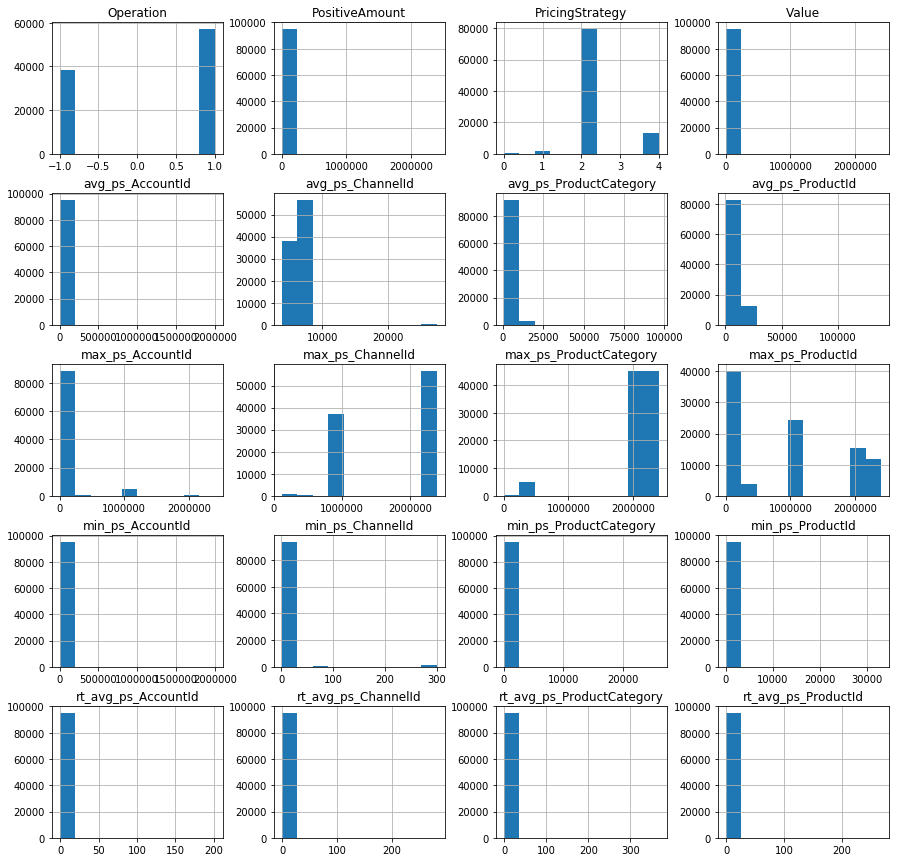

In [33]:
fraud_data.filter('Fraudresult == 0').toPandas().hist(column=numerical_features, figsize=(15,15))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc1b5371668>,
      dtype=object)

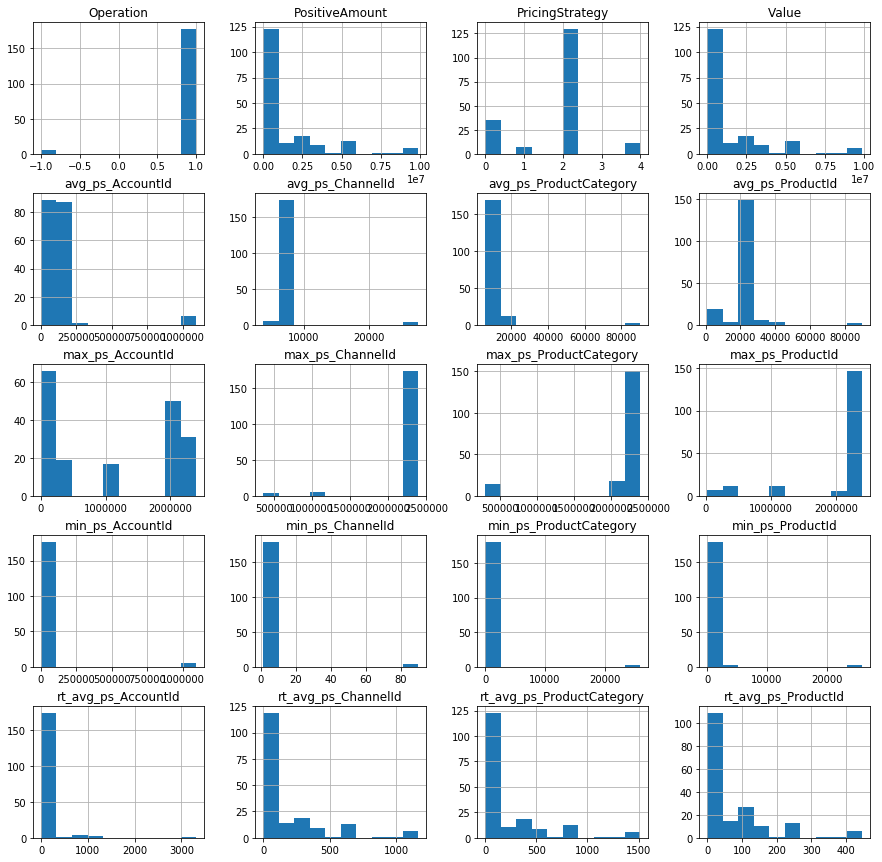

In [34]:
fraud_data.filter('FraudResult == 1').toPandas().hist(column=numerical_features, figsize=(15,15))

## Correlation

In [35]:
corr = []
def plot_heatmap(data, method):
  global corr 
  corr = data.corr(method)
  ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
  )
  ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right');

### Fraud data

,Value,PricingStrategy,Operation,PositiveAmount,avg_ps_AccountId,min_ps_AccountId,max_ps_AccountId,rt_avg_ps_AccountId,avg_ps_ChannelId,min_ps_ChannelId,max_ps_ChannelId,rt_avg_ps_ChannelId,avg_ps_ProductCategory,min_ps_ProductCategory,max_ps_ProductCategory,rt_avg_ps_ProductCategory,avg_ps_ProductId,min_ps_ProductId,max_ps_ProductId,rt_avg_ps_ProductId
Value,1.000000,-0.169240,0.131180,0.997215,0.403466,-0.054213,0.379112,0.591520,0.092480,0.092480,0.101160,0.951585,0.194439,-0.243971,0.245279,0.921249,0.266251,-0.195491,0.240190,0.811985
PricingStrategy,-0.169240,1.000000,-0.158950,-0.153024,-0.124016,-0.065837,-0.069166,0.042141,-0.080961,-0.080961,-0.155418,-0.139519,-0.269340,0.186465,-0.183918,-0.088350,-0.143507,0.207754,-0.194361,-0.043354
Operation,0.131180,-0.158950,1.000000,0.127634,0.225536,0.234038,0.052228,-0.074894,0.753638,0.753638,0.719767,-0.032652,0.314842,-0.247650,0.247650,0.051272,0.384133,-0.168889,0.321940,-0.061140
PositiveAmount,0.997215,-0.153024,0.127634,1.000000,0.403997,-0.072946,0.386366,0.596592,0.090326,0.090326,0.098060,0.954999,0.161926,-0.270746,0.272881,0.932752,0.280475,-0.217768,0.267799,0.807409
avg_ps_AccountId,0.403466,-0.124016,0.225536,0.403997,1.000000,0.198749,0.839146,-0.361835,0.047165,0.047165,0.292040,0.400793,-0.000431,-0.326579,0.323415,0.443928,0.017584,-0.349026,0.384448,0.384334
min_ps_AccountId,-0.054213,-0.065837,0.234038,-0.072946,0.198749,1.000000,-0.153773,-0.290967,0.098930,0.098930,0.250253,-0.069047,0.220878,-0.156906,0.150427,-0.107780,0.068854,-0.198534,0.223122,-0.093875
max_ps_AccountId,0.379112,-0.069166,0.052228,0.386366,0.839146,-0.153773,1.000000,-0.220521,-0.087227,-0.087227,0.171291,0.416098,-0.134630,-0.230562,0.227823,0.451564,-0.064889,-0.249628,0.293598,0.412520
rt_avg_ps_AccountId,0.591520,0.042141,-0.074894,0.596592,-0.361835,-0.290967,-0.220521,1.000000,0.054127,0.054127,-0.170688,0.581583,0.075578,0.044626,-0.039915,0.545840,0.175785,0.118221,-0.061251,0.522152
avg_ps_ChannelId,0.092480,-0.080961,0.753638,0.090326,0.047165,0.098930,-0.087227,0.054127,1.000000,1.000000,0.086142,-0.164400,0.237719,-0.227592,0.227592,0.041531,0.463520,0.009034,0.094518,-0.172990
min_ps_ChannelId,0.092480,-0.080961,0.753638,0.090326,0.047165,0.098930,-0.087227,0.054127,1.000000,1.000000,0.086142,-0.164400,0.237719,-0.227592,0.227592,0.041531,0.463520,0.009034,0.094518,-0.172990


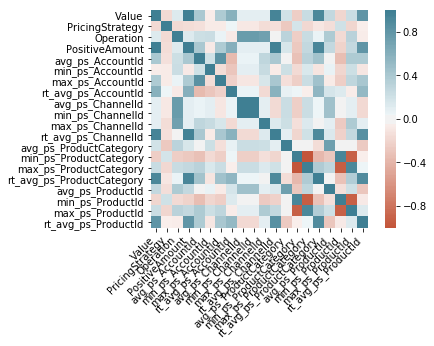

In [36]:
plot_heatmap(fraud_data.filter('FraudResult == 1').select(numerical_features).toPandas(), 'spearman')
corr

,Value,PricingStrategy,Operation,PositiveAmount,avg_ps_AccountId,min_ps_AccountId,max_ps_AccountId,rt_avg_ps_AccountId,avg_ps_ChannelId,min_ps_ChannelId,max_ps_ChannelId,rt_avg_ps_ChannelId,avg_ps_ProductCategory,min_ps_ProductCategory,max_ps_ProductCategory,rt_avg_ps_ProductCategory,avg_ps_ProductId,min_ps_ProductId,max_ps_ProductId,rt_avg_ps_ProductId
Value,1.000000,-0.076441,0.087939,0.999995,0.736420,0.707508,0.195288,0.003949,-0.037381,-0.051456,0.104579,0.997990,-0.052889,-0.031333,0.164912,0.997593,0.068655,-0.049713,0.215185,0.977124
PricingStrategy,-0.076441,1.000000,-0.188907,-0.076357,-0.037913,0.054511,-0.123027,0.040233,-0.004928,0.022607,-0.153228,-0.066699,0.014823,0.032338,-0.068772,-0.073078,-0.161325,0.051389,-0.231501,0.012018
Operation,0.087939,-0.188907,1.000000,0.087766,0.113559,0.039586,0.058111,0.029897,0.283754,0.146154,0.595199,0.042584,0.036914,0.018269,0.036775,0.080933,0.298272,0.007296,0.261850,-0.014384
PositiveAmount,0.999995,-0.076357,0.087766,1.000000,0.736527,0.707368,0.196025,0.004110,-0.037284,-0.051330,0.104353,0.997997,-0.053594,-0.031375,0.167686,0.997714,0.068444,-0.050072,0.217288,0.977181
avg_ps_AccountId,0.736420,-0.037913,0.113559,0.736527,1.000000,0.920973,0.307857,-0.163250,-0.062527,-0.081153,0.146992,0.734352,-0.102726,-0.082652,0.170380,0.739427,-0.004571,-0.103918,0.235620,0.718627
min_ps_AccountId,0.707508,0.054511,0.039586,0.707368,0.920973,1.000000,-0.057488,-0.049990,-0.022591,-0.029109,0.051907,0.706355,-0.033031,-0.026801,0.058945,0.705134,0.000928,-0.035389,0.081554,0.702713
max_ps_AccountId,0.195288,-0.123027,0.058111,0.196025,0.307857,-0.057488,1.000000,-0.241601,-0.133618,-0.146368,0.160382,0.199899,-0.181145,-0.132319,0.313584,0.210051,-0.047176,-0.163509,0.381089,0.180428
rt_avg_ps_AccountId,0.003949,0.040233,0.029897,0.004110,-0.163250,-0.049990,-0.241601,1.000000,-0.013404,-0.018211,0.036136,0.003718,0.542459,0.568184,-0.144481,-0.037556,0.467061,0.554767,-0.083910,-0.043232
avg_ps_ChannelId,-0.037381,-0.004928,0.283754,-0.037284,-0.062527,-0.022591,-0.133618,-0.013404,1.000000,0.990072,-0.601659,-0.082135,-0.013839,-0.012235,0.060873,-0.036805,0.296216,-0.002914,-0.183824,-0.091305
min_ps_ChannelId,-0.051456,0.022607,0.146154,-0.051330,-0.081153,-0.029109,-0.146368,-0.018211,0.990072,1.000000,-0.707959,-0.090978,-0.019688,-0.015300,0.057410,-0.049834,0.261874,-0.004076,-0.228028,-0.092088


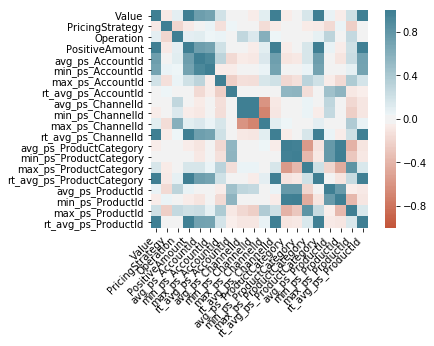

In [37]:
plot_heatmap(fraud_data.filter('FraudResult == 1').select(numerical_features).toPandas(), 'pearson')
corr

### Genuine data

,Value,PricingStrategy,Operation,PositiveAmount,avg_ps_AccountId,min_ps_AccountId,max_ps_AccountId,rt_avg_ps_AccountId,avg_ps_ChannelId,min_ps_ChannelId,max_ps_ChannelId,rt_avg_ps_ChannelId,avg_ps_ProductCategory,min_ps_ProductCategory,max_ps_ProductCategory,rt_avg_ps_ProductCategory,avg_ps_ProductId,min_ps_ProductId,max_ps_ProductId,rt_avg_ps_ProductId
Value,1.000000,0.220980,0.465563,0.999659,0.728425,0.628247,0.129355,0.853724,0.472159,0.472198,0.441072,0.978353,-0.225025,0.398223,-0.397253,0.988568,0.656286,0.482473,0.601391,0.878911
PricingStrategy,0.220980,1.000000,-0.040089,0.222614,0.216704,0.141824,0.013184,0.163345,-0.024289,0.029715,-0.052736,0.223530,-0.339066,0.276083,-0.276421,0.241727,0.095097,0.258803,0.143065,0.215762
Operation,0.465563,-0.040089,1.000000,0.464819,0.622979,0.754071,-0.093088,0.334662,0.992373,0.937900,0.974380,0.339818,-0.505544,0.613807,-0.613785,0.475375,0.763580,0.732708,0.754189,0.199150
PositiveAmount,0.999659,0.222614,0.464819,1.000000,0.728037,0.628361,0.128408,0.854163,0.471279,0.471141,0.440579,0.978936,-0.230547,0.393701,-0.392760,0.990236,0.654093,0.479699,0.603862,0.880254
avg_ps_AccountId,0.728425,0.216704,0.622979,0.728037,1.000000,0.757937,0.355762,0.330359,0.631009,0.627368,0.590474,0.645281,-0.481127,0.613943,-0.613478,0.734297,0.730170,0.686378,0.706684,0.516967
min_ps_AccountId,0.628247,0.141824,0.754071,0.628361,0.757937,1.000000,-0.120757,0.440306,0.753768,0.724489,0.727227,0.550182,-0.473607,0.567791,-0.567633,0.627456,0.723329,0.661028,0.717583,0.432167
max_ps_AccountId,0.129355,0.013184,-0.093088,0.128408,0.355762,-0.120757,1.000000,-0.176655,-0.095970,-0.112284,-0.091497,0.123282,-0.048668,0.118675,-0.118055,0.131570,0.022312,0.109912,-0.004032,0.124548
rt_avg_ps_AccountId,0.853724,0.163345,0.334662,0.854163,0.330359,0.440306,-0.176655,1.000000,0.338144,0.339505,0.320511,0.883082,-0.072667,0.201974,-0.201144,0.835148,0.468656,0.286530,0.423151,0.833754
avg_ps_ChannelId,0.472159,-0.024289,0.992373,0.471279,0.631009,0.753768,-0.095970,0.338144,1.000000,0.966970,0.940943,0.344149,-0.510993,0.626164,-0.626116,0.481587,0.770845,0.743854,0.758308,0.203848
min_ps_ChannelId,0.472198,0.029715,0.937900,0.471141,0.627368,0.724489,-0.112284,0.339505,0.966970,1.000000,0.866249,0.352604,-0.518578,0.639955,-0.639921,0.481531,0.764870,0.750469,0.749927,0.207869


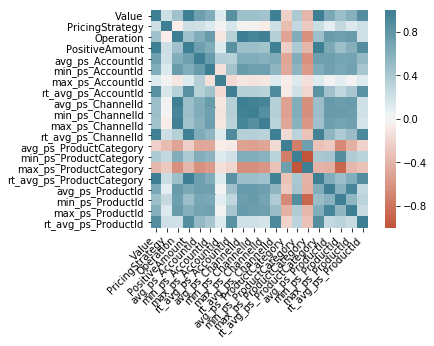

In [38]:
plot_heatmap(fraud_data.filter('FraudResult == 0').select(numerical_features).toPandas(), 'spearman')
corr

,Value,PricingStrategy,Operation,PositiveAmount,avg_ps_AccountId,min_ps_AccountId,max_ps_AccountId,rt_avg_ps_AccountId,avg_ps_ChannelId,min_ps_ChannelId,max_ps_ChannelId,rt_avg_ps_ChannelId,avg_ps_ProductCategory,min_ps_ProductCategory,max_ps_ProductCategory,rt_avg_ps_ProductCategory,avg_ps_ProductId,min_ps_ProductId,max_ps_ProductId,rt_avg_ps_ProductId
Value,1.000000,0.017029,5.896341e-02,0.999963,5.100844e-01,3.018056e-01,2.739691e-01,3.221125e-01,6.919767e-02,1.152192e-02,4.895213e-02,9.712164e-01,1.237937e-01,4.885120e-02,-4.935073e-02,9.833024e-01,2.260633e-01,1.046484e-01,1.253440e-01,7.556298e-01
PricingStrategy,0.017029,1.000000,-2.591971e-02,0.017595,7.282277e-02,-3.783297e-03,3.369737e-01,-1.026433e-02,-2.203710e-02,2.066206e-01,-4.865522e-02,9.704142e-02,-3.875407e-02,-1.489399e-02,-1.047817e-01,3.267350e-02,-3.889148e-02,1.140754e-02,1.101868e-01,1.033286e-01
Operation,0.058963,-0.025920,1.000000e+00,0.058304,1.143432e-01,5.895137e-02,-9.076804e-02,-2.070810e-05,8.539959e-01,2.094897e-02,9.684338e-01,-4.654152e-15,4.624213e-02,8.817306e-02,-4.042106e-01,4.816444e-02,4.567852e-01,1.517963e-01,6.295757e-01,-1.002471e-01
PositiveAmount,0.999963,0.017595,5.830411e-02,1.000000,5.099122e-01,3.019177e-01,2.742619e-01,3.214540e-01,6.827212e-02,1.103043e-02,4.850219e-02,9.714740e-01,1.222281e-01,4.776942e-02,-4.552027e-02,9.839376e-01,2.243363e-01,1.023523e-01,1.262590e-01,7.560823e-01
avg_ps_AccountId,0.510084,0.072823,1.143432e-01,0.509912,1.000000e+00,5.920974e-01,5.378610e-01,1.095532e-16,1.334625e-01,2.147554e-02,9.529714e-02,4.983234e-01,1.355224e-01,5.161190e-02,-8.474367e-02,4.877760e-01,2.699873e-01,1.035520e-01,2.087182e-01,3.623849e-01
min_ps_AccountId,0.301806,-0.003783,5.895137e-02,0.301918,5.920974e-01,1.000000e+00,3.113631e-02,-2.294172e-16,6.687425e-02,8.640891e-03,5.012462e-02,2.809188e-01,8.983397e-02,4.572866e-02,-3.038977e-02,2.859000e-01,1.115977e-01,4.525277e-02,6.197808e-02,1.803605e-01
max_ps_AccountId,0.273969,0.336974,-9.076804e-02,0.274262,5.378610e-01,3.113631e-02,1.000000e+00,9.501757e-16,-7.597215e-02,-4.277696e-02,-8.383454e-02,3.587116e-01,-4.024268e-03,1.713879e-03,-5.648506e-02,2.836895e-01,9.085740e-02,3.339960e-02,1.898674e-01,2.920032e-01
rt_avg_ps_AccountId,0.322113,-0.010264,-2.070810e-05,0.321454,1.095532e-16,-2.294172e-16,9.501757e-16,1.000000e+00,1.437107e-03,5.285587e-04,-6.191751e-04,3.379097e-01,9.340415e-02,4.438613e-02,4.525299e-04,3.098231e-01,1.871137e-01,5.728568e-02,7.236208e-02,4.695143e-01
avg_ps_ChannelId,0.069198,-0.022037,8.539959e-01,0.068272,1.334625e-01,6.687425e-02,-7.597215e-02,1.437107e-03,1.000000e+00,1.615657e-01,7.104246e-01,2.802841e-15,7.529176e-02,8.368698e-02,-3.732565e-01,4.963510e-02,4.388960e-01,1.822307e-01,5.338186e-01,-8.057087e-02
min_ps_ChannelId,0.011522,0.206621,2.094897e-02,0.011030,2.147554e-02,8.640891e-03,-4.277696e-02,5.285587e-04,1.615657e-01,1.000000e+00,-1.464214e-01,-1.906659e-15,2.480593e-02,3.618553e-02,-1.626158e-01,4.758134e-03,9.038964e-02,7.479725e-02,1.033263e-01,-2.267121e-02


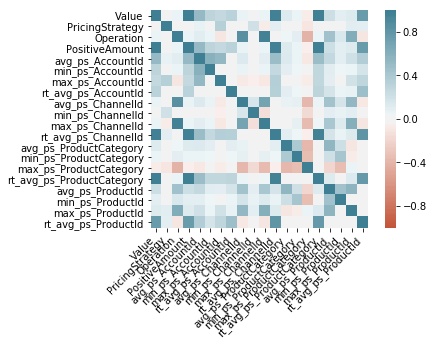

In [39]:
plot_heatmap(fraud_data.filter('FraudResult == 0').select(numerical_features).toPandas(), 'pearson')
corr

## Covariance

In [40]:
cov_ = []
def plot_heatmap_covariance(data):
  global cov_ 
  cov_ = data.cov()
  ax = sns.heatmap(
    cov_, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
  )
  ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right');

,Value,PricingStrategy,Operation,PositiveAmount,avg_ps_AccountId,min_ps_AccountId,max_ps_AccountId,rt_avg_ps_AccountId,avg_ps_ChannelId,min_ps_ChannelId,max_ps_ChannelId,rt_avg_ps_ChannelId,avg_ps_ProductCategory,min_ps_ProductCategory,max_ps_ProductCategory,rt_avg_ps_ProductCategory,avg_ps_ProductId,min_ps_ProductId,max_ps_ProductId,rt_avg_ps_ProductId
Value,4.532144e+12,-159330.929412,61206.509338,4.533909e+12,2.949664e+11,2.939803e+11,3.960385e+11,2.485933e+06,-2.310141e+08,-1.298444e+06,8.280266e+10,5.359294e+08,-1.011460e+09,-1.807336e+08,1.951233e+11,6.999113e+08,1.366172e+09,-2.894296e+08,3.179578e+11,1.996156e+08
PricingStrategy,-1.593309e+05,0.958626,-0.060470,-1.592191e+05,-6.984091e+03,1.041702e+04,-1.147456e+05,1.164707e+01,-1.400585e+01,2.623671e-01,-5.579715e+04,-1.647305e+01,1.303715e+02,8.578834e+01,-3.742329e+04,-2.358040e+01,-1.476414e+03,1.376003e+02,-1.573196e+05,1.129142e+00
Operation,6.120651e+04,-0.060470,0.106888,6.110995e+04,6.985208e+03,2.526019e+03,1.809820e+04,2.889957e+00,2.693002e+02,5.663844e-01,7.237255e+04,3.511867e+00,1.084145e+02,1.618329e+01,6.682279e+03,8.720218e+00,9.115054e+02,6.523533e+00,5.941842e+04,-4.512727e-01
PositiveAmount,4.533909e+12,-159219.131238,61109.953162,4.535720e+12,2.951255e+11,2.940380e+11,3.976886e+11,2.588122e+06,-2.305033e+08,-1.295779e+06,8.265632e+10,5.361448e+08,-1.025336e+09,-1.810496e+08,1.984835e+11,7.002729e+08,1.362507e+09,-2.916374e+08,3.211911e+11,1.997060e+08
avg_ps_AccountId,2.949664e+11,-6984.090661,6985.207864,2.951255e+11,3.539895e+10,3.382024e+10,5.517648e+10,-9.081436e+06,-3.415001e+07,-1.809820e+05,1.028578e+10,3.485209e+07,-1.736228e+08,-4.213449e+07,1.781633e+10,4.584884e+07,-8.038871e+06,-5.346948e+07,3.076885e+10,1.297453e+07
min_ps_AccountId,2.939803e+11,10417.020537,2526.018519,2.940380e+11,3.382024e+10,3.809515e+10,-1.068854e+10,-2.884828e+06,-1.279990e+07,-6.734491e+04,3.767947e+09,3.477661e+07,-5.791392e+07,-1.417342e+07,6.394152e+09,4.535700e+07,1.693730e+06,-1.888948e+07,1.104806e+10,1.316151e+07
max_ps_AccountId,3.960385e+11,-114745.622410,18098.198523,3.976886e+11,5.517648e+10,-1.068854e+10,9.074429e+11,-6.804788e+07,-3.694938e+08,-1.652697e+06,5.682148e+10,4.803411e+07,-1.550122e+09,-3.415247e+08,1.660226e+11,6.594366e+07,-4.200582e+08,-4.259633e+08,2.519651e+11,1.649328e+07
rt_avg_ps_AccountId,2.485933e+06,11.647073,2.889957,2.588122e+06,-9.081436e+06,-2.884828e+06,-6.804788e+07,8.742027e+04,-1.150457e+04,-6.382244e+01,3.973739e+06,2.772855e+02,1.440799e+06,4.551830e+05,-2.374225e+07,-3.659514e+03,1.290810e+06,4.485777e+05,-1.721971e+07,-1.226601e+03
avg_ps_ChannelId,-2.310141e+08,-14.005849,269.300158,-2.305033e+08,-3.415001e+07,-1.279990e+07,-3.694938e+08,-1.150457e+04,8.426789e+06,3.406713e+04,-6.495752e+08,-6.014325e+04,-3.608748e+05,-9.623180e+04,9.821104e+07,-3.521112e+04,8.037520e+06,-2.313329e+04,-3.703715e+08,-2.543432e+04
min_ps_ChannelId,-1.298444e+06,0.262367,0.566384,-1.295779e+06,-1.809820e+05,-6.734491e+04,-1.652697e+06,-6.382244e+01,3.406713e+04,1.404997e+02,-3.120999e+06,-2.720208e+02,-2.096378e+03,-4.913886e+02,3.782064e+05,-1.946727e+02,2.901429e+04,-1.321198e+02,-1.875992e+06,-1.047452e+02


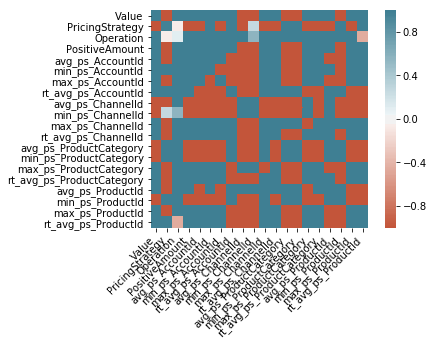

In [41]:
plot_heatmap_covariance( fraud_data.filter('FraudResult == 1').select(numerical_features).toPandas() )
cov_

## Outlier Analysis

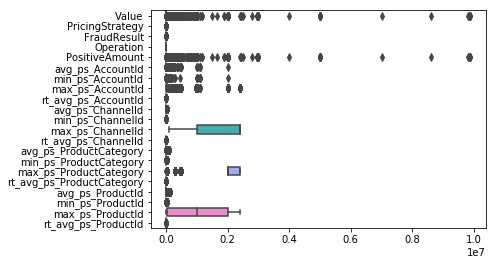

In [42]:
sns.boxplot(data=fraud_data.toPandas(), orient="h")

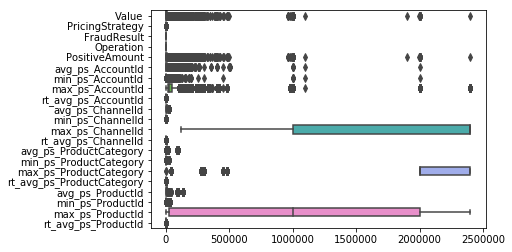

In [43]:
sns.boxplot(data=fraud_data.filter('FraudResult == 0').toPandas(), orient="h")

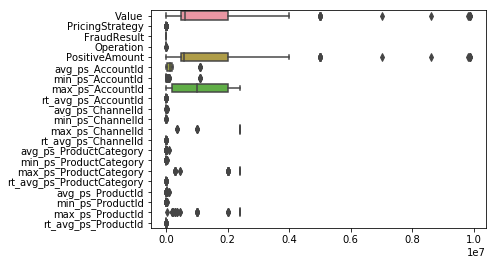

In [44]:
sns.boxplot(data=fraud_data.filter('FraudResult == 1').toPandas(), orient="h")

# Isolation Forest

In [45]:
def split_dataset_convertingToPandas(df, features, label):
  df_x = df.select(features).toPandas()
  df_y = df.select(label).toPandas()

  X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.3, random_state=42)
  return X_train, X_test, y_train, y_test

In [46]:
X_train, X_test, y_train, y_test = split_dataset_convertingToPandas(fraud_data, numerical_features, label)
X_outliers = fraud_data.filter('FraudResult==1').select(numerical_features).toPandas()

## Isolation Forest Classifier Functions

In [47]:
# Input:
# TP | FP
# FN | TN

# Output:
#   F1-score
def compute_f1score(data):
  tp = data[0][0]
  fp = data[0][1]
  fn = data[1][0]
  tn = data[1][1]
  # sensitivity, recall, hit rate, or true positive rate (TPR)
  tpr = tp / (tp+fn)
  # precision or positive predictive value (PPV)
  ppv = tp / (tp+fp)
  # F1 score is the harmonic mean of precision and sensitivity
  f1_score = 2 * (ppv*tpr) / (ppv+tpr)
  return f1_score

In [48]:
# Input: Positive=-1 and Negative=1
# Output: Positive=1 and Negative=0
def norm_pred(data):
  data = ((data*-1)+1)/2
  return data

def train_isolation_forest(X_train, X_test, y_train, y_test, X_outliers, max_sample_list, cont_list):
  # fit the model
  rng = np.random.RandomState(42)

  graph_performance = pd.DataFrame([], columns=['f1','max','cont'])

  for max_sample in max_sample_list:
    for cont in cont_list:

      clf = IsolationForest(behaviour='new', max_samples=max_sample,
                            random_state=rng, contamination=cont, n_jobs=10)

      clf.fit(X_train)

      y_pred_train = clf.predict(X_train)
      y_pred_test = clf.predict(X_test)
      y_pred_outliers = clf.predict(X_outliers)

      y_pred_test = norm_pred(y_pred_test)
      y_pred_outliers = norm_pred(y_pred_outliers)

      cm = confusion_matrix(y_test, y_pred_test)
      f1_score = compute_f1score(cm)
  
      new_row = pd.DataFrame({'f1':[f1_score], 'max':[max_sample], 'cont':[cont]})
      graph_performance = graph_performance.append(new_row)
  return graph_performance, clf

In [49]:
def plot_perfomance_clf(perf_arr):
    sns.set(style='darkgrid')
    return sns.lineplot(x='max', y='f1', hue='cont',  data = perf_arr), perf_arr[perf_arr.f1 == perf_arr.f1.max()]

In [50]:
max_sample_arr = np.arange(200, 1000, 200)
contamination_arr = np.arange(.05, .5, .05)

## Applying IF using Data Imbalance

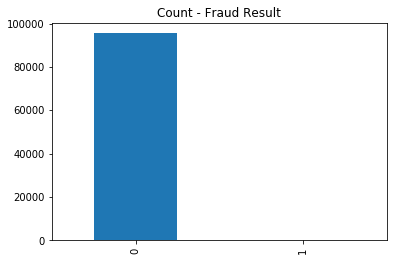

In [51]:
pd.Series((fraud_data.toPandas())[label]).value_counts().plot.bar(title='Count - Fraud Result')

In [52]:
imbalance_perfomance_arr, imbal_clf = train_isolation_forest(X_train, X_test, y_train, y_test, X_outliers, max_sample_arr, contamination_arr)

(<matplotlib.axes._subplots.AxesSubplot at 0x7fc1b5623198>,
          f1  max  cont
 0  0.976602  800  0.05)

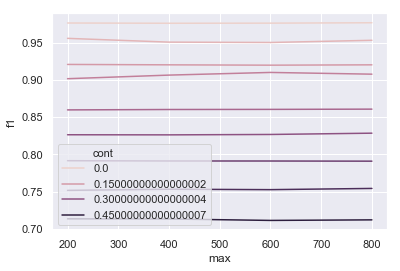

In [53]:
plot_perfomance_clf(imbalance_perfomance_arr)

# Balancing Data

In [54]:
def over_sampler(df, features, label, method):
    X_ = df.select(features).toPandas()
    y_ = df.select(label).toPandas()
    over_sampler = method(random_state=42)
    return over_sampler.fit_resample(X_, y_)

In [55]:
def balance_dataframe_smotenc(data, features, label, categorical_pos):
  sm = SMOTENC(categorical_features=categorical_pos, random_state = 42)
  data_pd = data.toPandas()
  X_train_new, y_train_new = sm.fit_sample(data_pd[features], data_pd[label].ravel())
  X_train_new = pd.DataFrame(X_train_new, columns=all_features)
  y_train_new = pd.DataFrame(y_train_new, columns=[label])
  return X_train_new, y_train_new

In [56]:
X_smotenc, y_smotenc = balance_dataframe_smotenc(fraud_data, all_features, label, categorical_features_dims)

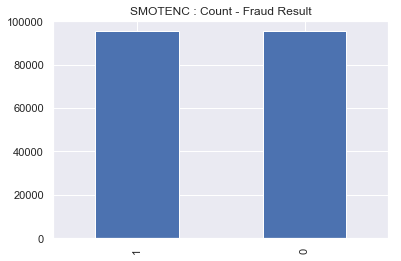

In [57]:
pd.Series(y_smotenc[label]).value_counts().plot.bar(title='SMOTENC : Count - Fraud Result')

## Isolation Forest Evaluation using SMOTENC

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X_smotenc[numerical_features], y_smotenc, test_size=0.3, random_state=42)
X_outliers = X_smotenc[y_smotenc['FraudResult']==1][numerical_features]

In [59]:
smotenc_perfomance_arr, smotenc_clf = train_isolation_forest(X_train, X_test, y_train, y_test, X_outliers, max_sample_arr, contamination_arr)

(<matplotlib.axes._subplots.AxesSubplot at 0x7fc1b2e587b8>,
          f1  max  cont
 0  0.721341  200   0.3)

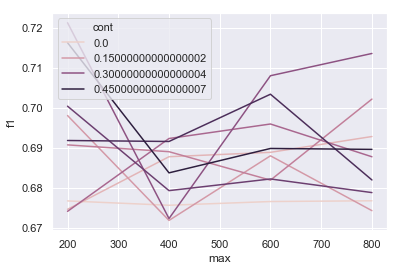

In [60]:
plot_perfomance_clf(smotenc_perfomance_arr)

# Learning Curve

In [61]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 10)):
    '''
    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    '''
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [62]:
X, y = X_smotenc[numerical_features], y_smotenc

crossvalidation_smotenc = ShuffleSplit(n_splits=100, test_size=0.25, random_state=42)

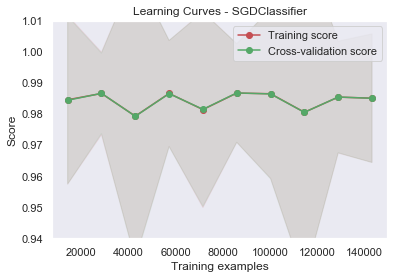

/home/dunfrey/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/dunfrey/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/dunfrey/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/dunfrey/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped whil

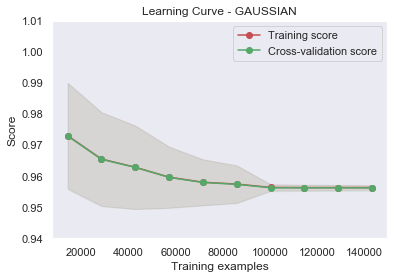

In [63]:
title = "Learning Curve - GAUSSIAN"
estimator = GaussianNB()
# n-jobs: quantidade de processadores executando
# (0.94, 1.01): margen do eixo y
plot_learning_curve(estimator, title, X, y, (0.94, 1.01), cv=crossvalidation_smotenc, n_jobs=10)
plt.show()

# Catboost Model

###  SEM Isolation Forest Prediction

In [64]:
params = {'depth' : [3, 4, 5],
                  'loss_function': ['Logloss'],
                  'eval_metric': ['AUC', 'F1'],
                  'iterations' : [30, 50, 100, 150]
                  }

X = X_smotenc[numerical_features]
y = y_smotenc

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [65]:
model = CatBoostClassifier(eval_metric='AUC')
grid = GridSearchCV( estimator = model, param_grid = params, cv = 4, n_jobs = 5 )
grid.fit( X_train, y_train )

Learning rate set to 0.5
0:	total: 64ms	remaining: 6.33s
1:	total: 79.3ms	remaining: 3.89s
2:	total: 97.8ms	remaining: 3.16s
3:	total: 116ms	remaining: 2.77s
4:	total: 144ms	remaining: 2.73s
5:	total: 166ms	remaining: 2.59s
6:	total: 189ms	remaining: 2.51s
7:	total: 215ms	remaining: 2.47s
8:	total: 229ms	remaining: 2.31s
9:	total: 243ms	remaining: 2.19s
10:	total: 264ms	remaining: 2.13s
11:	total: 279ms	remaining: 2.04s
12:	total: 292ms	remaining: 1.96s
13:	total: 306ms	remaining: 1.88s
14:	total: 320ms	remaining: 1.81s
15:	total: 336ms	remaining: 1.76s
16:	total: 363ms	remaining: 1.77s
17:	total: 390ms	remaining: 1.77s
18:	total: 403ms	remaining: 1.72s
19:	total: 423ms	remaining: 1.69s
20:	total: 450ms	remaining: 1.69s
21:	total: 466ms	remaining: 1.65s
22:	total: 480ms	remaining: 1.61s
23:	total: 494ms	remaining: 1.56s
24:	total: 517ms	remaining: 1.55s
25:	total: 529ms	remaining: 1.5s
26:	total: 554ms	remaining: 1.5s
27:	total: 580ms	remaining: 1.49s
28:	total: 594ms	remaining: 1.46s


GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=<catboost.core.CatBoostClassifier object at 0x7fc1b327c080>,
             iid='warn', n_jobs=5,
             param_grid={'depth': [3, 4, 5], 'eval_metric': ['AUC', 'F1'],
                         'iterations': [30, 50, 100, 150],
                         'loss_function': ['Logloss']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [66]:
print("\n The best score across ALL searched params:\n",
      grid.best_score_)

print("\n The best parameters across ALL searched params:\n",
      grid.best_params_)


 The best score across ALL searched params:
 0.9997082061411384

 The best parameters across ALL searched params:
 {'depth': 4, 'eval_metric': 'AUC', 'iterations': 100, 'loss_function': 'Logloss'}


## Add outlier feature estimation

In [67]:
predictions = smotenc_clf.predict(X_smotenc[numerical_features])
X_smotenc_if = X_smotenc
X_smotenc_if['IsolationForest'] = predictions
numerical_features.append('IsolationForest')

### COM Isolation Forest

In [68]:
X = X_smotenc_if[numerical_features]
y = y_smotenc

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [69]:
grid = GridSearchCV( estimator = model, param_grid = params, cv = 4, n_jobs = 5 )
grid.fit( X_train, y_train )

/home/dunfrey/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Learning rate set to 0.362979
0:	total: 21.3ms	remaining: 3.18s
1:	total: 51ms	remaining: 3.78s
2:	total: 84.3ms	remaining: 4.13s
3:	total: 118ms	remaining: 4.31s
4:	total: 148ms	remaining: 4.29s
5:	total: 177ms	remaining: 4.25s
6:	total: 207ms	remaining: 4.22s
7:	total: 220ms	remaining: 3.91s
8:	total: 240ms	remaining: 3.75s
9:	total: 255ms	remaining: 3.57s
10:	total: 281ms	remaining: 3.55s
11:	total: 310ms	remaining: 3.57s
12:	total: 325ms	remaining: 3.43s
13:	total: 347ms	remaining: 3.37s
14:	total: 361ms	remaining: 3.25s
15:	total: 382ms	remaining: 3.2s
16:	total: 396ms	remaining: 3.1s
17:	total: 415ms	remaining: 3.05s
18:	total: 432ms	remaining: 2.98s
19:	total: 450ms	remaining: 2.93s
20:	total: 475ms	remaining: 2.92s
21:	total: 490ms	remaining: 2.85s
22:	total: 505ms	remaining: 2.79s
23:	total: 519ms	remaining: 2.73s
24:	total: 533ms	remaining: 2.66s
25:	total: 546ms	remaining: 2.6s
26:	total: 562ms	remaining: 2.56s
27:	total: 576ms	remaining: 2.51s
28:	total: 591ms	remaining: 2.

GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=<catboost.core.CatBoostClassifier object at 0x7fc1a28f8e10>,
             iid='warn', n_jobs=5,
             param_grid={'depth': [3, 4, 5], 'eval_metric': ['AUC', 'F1'],
                         'iterations': [30, 50, 100, 150],
                         'loss_function': ['Logloss']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [70]:
print("\n The best score across ALL searched params:\n",
      grid.best_score_)

print("\n The best parameters across ALL searched params:\n",
      grid.best_params_)


 The best score across ALL searched params:
 0.9997530975040402

 The best parameters across ALL searched params:
 {'depth': 4, 'eval_metric': 'AUC', 'iterations': 150, 'loss_function': 'Logloss'}


## Feature Importance

In [71]:
model.fit(X_smotenc_if, y_smotenc, verbose=False, plot=True, cat_features=categorical_features)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [72]:
shap.initjs()

shap_values = model.get_feature_importance(Pool(X_smotenc, y_smotenc, cat_features=categorical_features_dims), type='ShapValues')
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

# visualize the first prediction's explanation
shap.force_plot(expected_value, shap_values[200,:], X_smotenc.iloc[200,:])

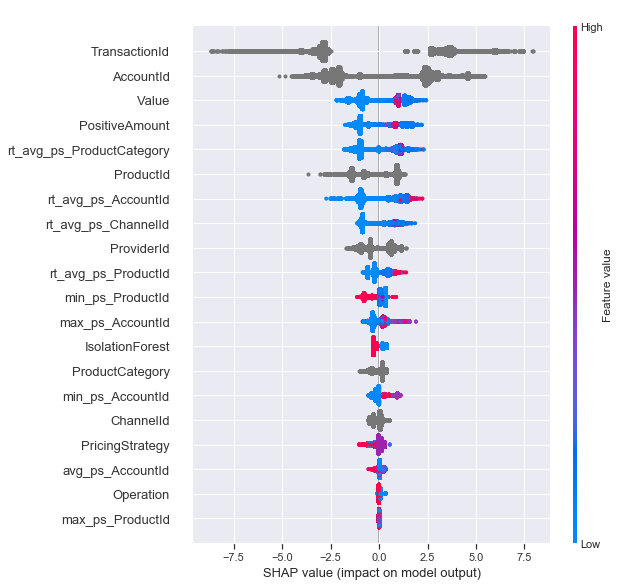

In [73]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_smotenc_if)

# Evaluation

In [74]:
test_data = read_data_from_web("https://drive.google.com/uc?export=download&id=16cRQIFW6n2th2YOK7DEsp9dQgihHDuHa")
test_bkp = test_data

In [75]:
test_data = test_data.withColumn('PositiveAmount', F.abs(test_data['Amount']))
test_data = test_data.withColumn("Operation", F.when(test_data.Amount > 0, 1).when(test_data.Amount < 0, -1).otherwise(0))
test_data = remove_feature(test_data, columns_to_remove)

In [76]:
columns_to_remove = ['CurrencyCode','CountryCode','BatchId','SubscriptionId','CustomerId', 'TransactionStartTime']
fraud_data = clean_data(fraud_data, columns_to_remove)

In [77]:
def get_features_augmentation_test(df, clean=False):
  gen_train_data = df
  items_list = ['AccountId', 'ChannelId', 'ProductCategory', 'ProductId']

  for item in items_list:
    mean_column_name = 'avg_ps_{0}'.format(item)
    mean_aux = gen_train_data.select([item,'PositiveAmount']).groupBy(item).mean()
    mean_aux = mean_aux.select(col(item), col('avg(PositiveAmount)').alias(mean_column_name))
    df = df.join(mean_aux, on=item)

    min_column_name = 'min_ps_{0}'.format(item)
    min_aux = gen_train_data.select([item,'PositiveAmount']).groupBy(item).min()    
    min_aux = min_aux.select(col(item), col('min(PositiveAmount)').alias(min_column_name))
    df = df.join(min_aux, on=item)

    max_column_name = 'max_ps_{0}'.format(item)
    max_aux = gen_train_data.select([item,'PositiveAmount']).groupBy(item).max()    
    max_aux = max_aux.select(col(item), col('max(PositiveAmount)').alias(max_column_name))
    df = df.join(max_aux, on=item)
    
    ratio_column_name = 'rt_avg_ps_{0}'.format(item)
    df = df.withColumn(ratio_column_name, (F.col('PositiveAmount')-F.col(mean_column_name))/ F.col(mean_column_name))
  
  if clean:
    df = clean_data(df)
  
  return df

In [78]:
test_data = get_features_augmentation_test(test_data)
test_data = clean_data(test_data, columns_to_remove = ['Amount'])

In [79]:
test_data_pd = test_data.toPandas()

In [80]:
numerical_features = ['Value', 'PricingStrategy', 'Operation', 'PositiveAmount', 
                                        'avg_ps_AccountId','min_ps_AccountId','max_ps_AccountId','rt_avg_ps_AccountId',
                                        'avg_ps_ChannelId','min_ps_ChannelId','max_ps_ChannelId','rt_avg_ps_ChannelId',
                                        'avg_ps_ProductCategory','min_ps_ProductCategory','max_ps_ProductCategory','rt_avg_ps_ProductCategory',
                                        'avg_ps_ProductId','min_ps_ProductId','max_ps_ProductId','rt_avg_ps_ProductId']

In [81]:
predictions = smotenc_clf.predict(test_data_pd[numerical_features])
test_data_pd['IsolationForest'] = predictions

In [82]:
test_predictions = model.predict( test_data_pd )

In [83]:
test_data = test_bkp

In [87]:
def save_predictions_xente(file_name, transactions_list, predictions_list):
  file = open(file_name,'w')
  file.write('TransactionId,FraudResult\n')
  for (trans_id, value) in zip(transactions_list, predictions_list):
    file.write('{0},{1}\n'.format(trans_id, int(value)))
  for item in (set(transactions_list)-trans_id):
    file.write('{0},0\n'.format(item))
  file.close()

In [85]:
file_name = 'xento_predictions.csv'  
transactions_list = list(test_data.select('TransactionId').toPandas()['TransactionId'])

In [ ]:
save_predictions_xente(file_name, transactions_list, test_predictions)

In [89]:
print('Concluido')

Concluido
